## <center>Modelling A Mean-Reverting Portfolio using the OU Process</center>

### 1. Prepare Data

In [1]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

def get_filtered_data(data, start_yr, end_yr):
    filt_data = data.copy()
    filt_data['Date'] = pd.to_datetime(filt_data['Date'], format='%d/%m/%Y')
    filt_data = filt_data.sort_values(['Date'])
    filt_data = filt_data[(filt_data['Date'].dt.year >= start_yr) & (filt_data['Date'].dt.year <= end_yr)]
    filt_data = filt_data.set_index(['Date'])
    return filt_data

def get_period_data(etf1, etf2, start_yr, end_yr):
    filtData1 = get_filtered_data(etf1, start_yr, end_yr)
    filtData2 = get_filtered_data(etf2, start_yr, end_yr)

    data = pd.concat([filtData1['Close'], filtData2['Close']], axis=1).dropna()
    data.columns = ['etf1', 'etf2']
    data['etf1_rets'] = np.log(data['etf1']/data['etf1'].shift(1))
    data['etf2_rets'] = np.log(data['etf2']/data['etf2'].shift(1))
    
    return data

path = '../OilFunds'
etf1 = pd.read_csv(path+os.sep+'IXC.csv')
etf2 = pd.read_csv(path+os.sep+'USO.csv')

period_1_data = get_period_data(etf1, etf2, 2011, 2014)
period_2_data = get_period_data(etf1, etf2, 2015, 2019)
period_3_data = get_period_data(etf1, etf2, 2011, 2019)

### 2. Check Co-integration

In [2]:
from statsmodels.tsa.stattools import coint

t_stat_1 = coint(period_1_data['etf1_rets'].dropna().values
                 ,period_1_data['etf2_rets'].dropna().values)[0]
t_stat_2 = coint(period_2_data['etf1_rets'].dropna().values
                 ,period_2_data['etf2_rets'].dropna().values)[0]
t_stat_3 = coint(period_3_data['etf1_rets'].dropna().values
                 ,period_3_data['etf2_rets'].dropna().values)[0]
print('Cointegration t-Statistic')
print('2011-2014:', t_stat_1)
print('2015-2019:', t_stat_2)
print('2011-2019:', t_stat_3)

Cointegration t-Statistic
2011-2014: -7.4313688331430905
2015-2019: -31.08967278727755
2011-2019: -11.905935397416538


### 3. Find OU Parameters

In [10]:
import matplotlib.pyplot as plt

def get_OU_params(port):
    X_x = np.sum(port.values[:-1])
    X_y = np.sum(port.values[1:])
    X_xx = np.sum((port.values[:-1])**2)
    X_xy = np.sum((port.values[:-1])*(port.values[1:]))
    X_yy = np.sum(port.values[1:]**2)
    
    n = len(port)
    dt = 1/252
    
    num = (X_y*X_xx) - (X_x*X_xy)
    den = n*(X_xx-X_xy) - ((X_x**2)-(X_x*X_y))
    theta = (num)/(den)

    num = (X_xy - (theta*X_x) - (theta*X_y) + (n*(theta**2)))
    den = X_xx - (2*theta*X_x) + (n*(theta**2))
    mu = -(1/dt)*(np.log(num/den))

    alpha = np.exp(-mu*dt)
    t1 = (2*mu)/(n*(1-(alpha**2)))
    t2 = X_yy - (2*alpha*X_xy) + ((alpha**2)*X_xx)
    t3 = 2*theta*(1-alpha)*(X_y - alpha*X_x) 
    t4 = n*(theta**2)*(1-alpha)**2
    sigma = np.sqrt(t1*(t2-t3+t4))

    return theta, mu, sigma

def avg_likelihood(params, port):
    n = len(port)
    dt = 1/252
    theta, mu, sigma = params
    
    sigma_tilde = (sigma**2)*(1-np.exp(-2*mu*dt))/(2*mu)
    sq_term = np.sum((port.values[1:] - (port.values[:-1]*(np.exp(-mu*dt)))\
                      - theta*(1-(np.exp(-mu*dt))))**2)
    l = -(0.5*np.log(2*np.pi)) - np.log(np.sqrt(sigma_tilde))\
                                        - (1/(2*n*sigma_tilde))*sq_term
    
    return l

def run_test(data):
    A = 1
    B = np.arange(0.001,1.001,0.001)
    l_hat = [0]*len(B)
    th = [0]*len(B)
    max_index = None
    ou_params = [None]*len(B)
    th = [None]*len(B)
    for i in range(len(B)):
        alpha = A/data.etf1.iloc[0]
        beta = B[i]/data.etf2.iloc[0]
        port = alpha*data.etf1-beta*data.etf2
        ou_params[i] = get_OU_params(port)
        th[i] = ou_params[i][0]
        l_hat[i] = avg_likelihood(ou_params[i], port) 
        if max_index is None or l_hat[i] > l_hat[max_index]:
            max_index = i

    plt.rcParams['figure.figsize'] = [12,6]
    plt.plot(B, l_hat);
    plt.axvline(x=B[max_index], color='red', linestyle='--')
    plt.xlabel('B');
    plt.ylabel('Average Log-Likelihood')
    
    opt_params = ou_params[max_index]
    opt_alpha = A/data.etf1.iloc[0]
    opt_beta = B[max_index]/data.etf2.iloc[0]
    opt_port = opt_alpha*data.etf1-opt_beta*data.etf2
    return (opt_params, avg_likelihood(opt_params, opt_port), 
            A, B[max_index], opt_alpha, opt_beta)

#### 3.1 Find Parameters for Period 1: 2011-2014

Results for 2011-2014
Optimal Parameters: (0.5425660818784224, 1.942162257172824, 0.16008225347840174)
Maximum Average Likelihood: 3.1817775281810023
Optimal Cash Level for IXC, A: 1
Optimal Cash Level for USO, B: 0.5690000000000001
Optimal Alpha: 0.025396825396825397
Optimal Beta: 0.014571062740076827


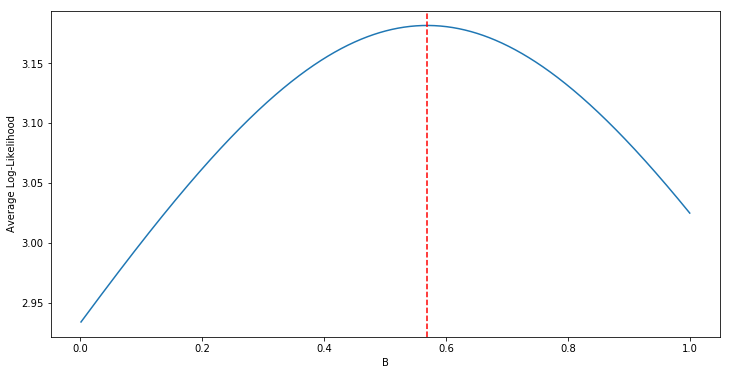

In [4]:
params_1, max_avg_likelihood_1, A_1, B_1, alpha_1, beta_1\
                                        = run_test(period_1_data)
print('Results for 2011-2014')
print('Optimal Parameters:', params_1)
print('Maximum Average Likelihood:', max_avg_likelihood_1)
print('Optimal Cash Level for IXC, A:', A_1)
print('Optimal Cash Level for USO, B:', B_1)
print('Optimal Alpha:', alpha_1)
print('Optimal Beta:', beta_1)

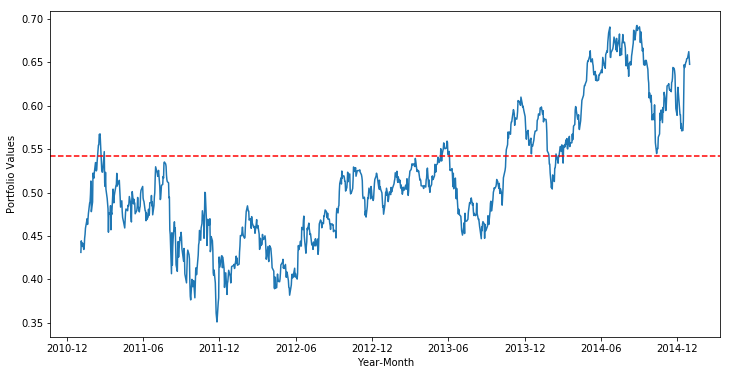

In [5]:
opt_port_1 = alpha_1*period_1_data.etf1-beta_1*period_1_data.etf2 
plt.plot(opt_port_1)
plt.axhline(y=params_1[0], color='red', linestyle='--')
plt.xlabel('Year-Month');
plt.ylabel('Portfolio Values');

#### 3.2 Find Parameters for Period 2: 2015-2019

Results for 2015-2019
Optimal Parameters: (0.5590829217915558, 1.9563330358909465, 0.12694142572618333)
Maximum Average Likelihood: 3.413817999392501
Optimal Cash Level for IXC, A: 1
Optimal Cash Level for USO, B: 0.548
Optimal Alpha: 0.026874496103198066
Optimal Beta: 0.027551533433886378


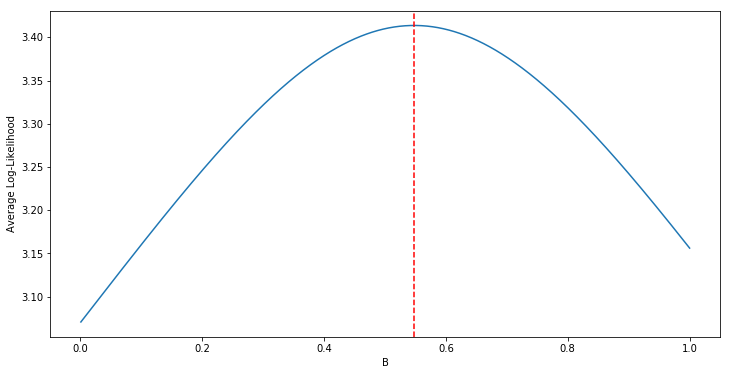

In [6]:
params_2, max_avg_likelihood_2, A_2, B_2, alpha_2, beta_2 = run_test(period_2_data)
print('Results for 2015-2019')
print('Optimal Parameters:', params_2)
print('Maximum Average Likelihood:', max_avg_likelihood_2)
print('Optimal Cash Level for IXC, A:', A_2)
print('Optimal Cash Level for USO, B:', B_2)
print('Optimal Alpha:', alpha_2)
print('Optimal Beta:', beta_2)

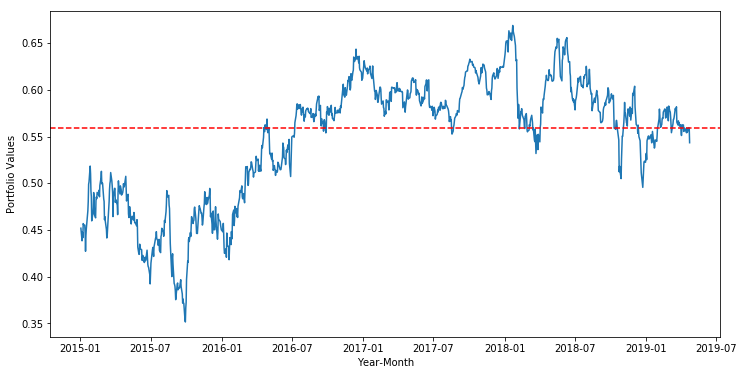

In [7]:
opt_port_2 = alpha_2*period_2_data.etf1-beta_2*period_2_data.etf2 
plt.plot(opt_port_2)
plt.axhline(y=params_2[0], color='red', linestyle='--')
plt.xlabel('Year-Month');
plt.ylabel('Portfolio Values');

#### 3.3 Find Parameters for Period 3: 2011-2019

Results for 2011-2019
Optimal Parameters: (0.5773107414211032, 0.7903586772294122, 0.14442018397384732)
Maximum Average Likelihood: 3.2823811230997695
Optimal Cash Level for IXC, A: 1
Optimal Cash Level for USO, B: 0.67
Optimal Alpha: 0.025396825396825397
Optimal Beta: 0.01715749039692702


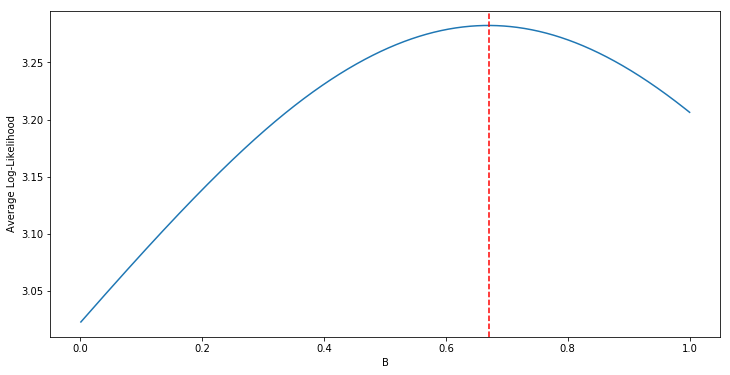

In [8]:
params_3, max_avg_likelihood_3, A_3, B_3, alpha_3, beta_3 = run_test(period_3_data)
print('Results for 2011-2019')
print('Optimal Parameters:', params_3)
print('Maximum Average Likelihood:', max_avg_likelihood_3)
print('Optimal Cash Level for IXC, A:', A_3)
print('Optimal Cash Level for USO, B:', B_3)
print('Optimal Alpha:', alpha_3)
print('Optimal Beta:', beta_3)

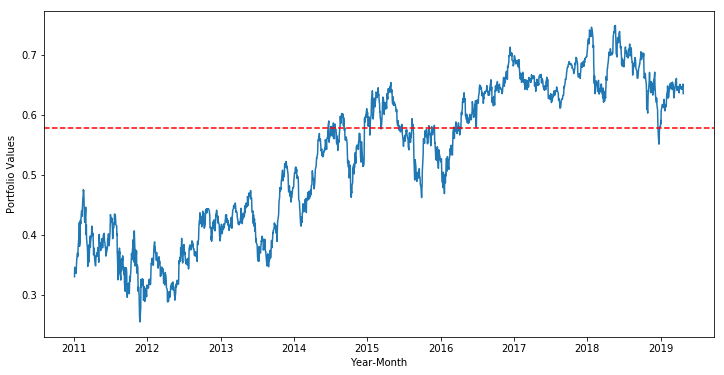

In [9]:
opt_port_3 = alpha_3*period_3_data.etf1-beta_3*period_3_data.etf2 
plt.plot(opt_port_3)
plt.axhline(y=params_3[0], color='red', linestyle='--')
plt.xlabel('Year-Month');
plt.ylabel('Portfolio Values');